In [ ]:
# Author: Papiya Sen 

# This file is part of the project 'Gene Methylation'. 
# In this file, I generated Linear regression models for 450k sites with factors - Age,
# BMI, Smoking status. Applied multiple testing correction to find the significant sites.
# Then sorted the sites based on correlation to find top differentially methylated sites, 
# which match results reported in litearture.



In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.stats.multitest as smm


In [2]:
with open("newmatrix.csv") as file:
    read_file = csv.reader(file)
    Data = list(line for line in read_file)
file.close()

In [4]:
Sample_Names = Data[0] # patient ID
Site_Names = list(line[0] for line in Data[1:]) # CpG sites
Beta_Matrix = list(list(map(float, line[1:])) for line in Data[1:]) # beta values
beta_value= np.stack(Beta_Matrix)

m_value = np.log2(beta_value/(1 - beta_value)) # convert beta to M-values
# m_value.shape

In [6]:
import pandas as pd
from sklearn import preprocessing

df_age = pd.read_csv('/Users/papiya/Desktop/CU_Capstone/Dataset/age.csv')
df_age = df_age.drop(df_age.columns[0], axis=1)
df_bmi = pd.read_csv('/Users/papiya/Desktop/CU_Capstone/Dataset/bmiStatus.csv')
df_bmi = df_bmi.drop(df_bmi.columns[0], axis=1)
df_smok = pd.read_csv('/Users/papiya/Desktop/CU_Capstone/Dataset/smoking_status.csv')
df_smok = df_smok.drop(df_smok.columns[0], axis=1)
df_smok = df_smok[df_smok.columns[0]].astype('object')
s = pd.Series(list('012')) # one hot encoding 'smoking status'
df_smok = pd.get_dummies(df_smok)


# combine all the factors - age, bmi, smoking status
df_start = pd.concat([df_age, df_bmi, df_smok], axis=1, ignore_index=True)
df_start.columns = ['Age', 'BMI', 'Smoke_0', 'Smoke_1', 'Smoke_2'] # Smoke_0: doesn't smoke, Smoke_1: smoker, Smoke_2: ex-smoker

df_start.head(2)


,Age,BMI,Smoke_0,Smoke_1,Smoke_2
0,42.69,18.7,0,0,1
1,67.75,35.9,1,0,0


In [7]:
df = df_start.drop('Smoke_0', axis = 1)
df.head(2)

,Age,BMI,Smoke_1,Smoke_2
0,42.69,18.7,0,1
1,67.75,35.9,0,0


In [8]:
# Renaming
sample_id = Sample_Names
site_id = Site_Names
beta_values = beta_value
m_values = m_value

X = df.values # convert to array

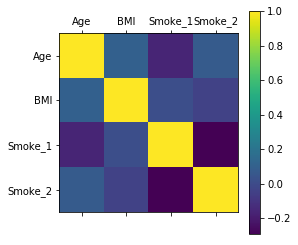

In [9]:

%matplotlib inline

#check correlation

correlation_matrix = np.corrcoef(X.T)
#print(correlation_matrix) 

names = ['Age', 'BMI', 'Quit smoking', 'Smoking']# , 'Interaction']
plt.matshow(df.corr())
plt.xticks( range(4), ('Age', 'BMI', 'Smoke_1', 'Smoke_2')) #, 'Age*BMI') )
plt.yticks( range(4), ('Age', 'BMI', 'Smoke_1', 'Smoke_2')) #, 'Age*BMI') )
plt.colorbar()
plt.show()

In [26]:
# generate lin regression model for each site using factors in X

lr_m = LinearRegression(fit_intercept= True, n_jobs= -1)  # data does not have zero mean so using True for Intercept
lr_m.fit(X, m_values.T)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [27]:
# calculating p-values
mse = np.sum((lr_m.predict(X) - m_values.T)**2 , axis = 0)/ float(X.shape[0] - X.shape[1])
se = np.array([np.sqrt(np.diagonal(mse[i] * np.linalg.inv(np.dot(X.T, X)) )) for i in range(mse.shape[0])]) 
t_m = lr_m.coef_/ se
p_m = 2 * (1 - stats.t.cdf(np.abs(t_m), X.shape[0] - X.shape[1])) # p_m shape is ((m_values.T).shape[1], X.shape[1]) => (450531,4)


In [43]:
# extracting p-values for each factor across ALL sites

pval_age = [p_m[i][0] for i in range(len(p_m))]
pval_bmi = [p_m[i][1] for i in range(len(p_m))]
pval_smk1 = [p_m[i][2] for i in range(len(p_m))]
pval_smk2 = [p_m[i][3] for i in range(len(p_m))]
#pval_AgeeBMI = [p_m[i][4] for i in range(len(p_m))]
#pval_age[0:10]

In [44]:
## Applying multiple test correction
# separate out sites by significant factors

alpha = 0.01 # assuming 1% risk allowable (although 5% is also common)
method = 'b' # false discovery rate using Benjamini-Hochberg method
p_sig = 0.01

pval_age_corr = smm.multipletests(pval_age, alpha=alpha, method=method)[1]
pval_bmi_corr = smm.multipletests(pval_bmi, alpha=alpha, method=method)[1]
pval_smk1_corr = smm.multipletests(pval_smk1, alpha=alpha, method=method)[1]
pval_smk2_corr = smm.multipletests(pval_smk2, alpha=alpha, method=method)[1]
#pval_AgeeBMI_corr = smm.multipletests(pval_AgeeBMI, alpha=alpha, method=method)[1]

age_loc = np.where(pval_age_corr < p_sig) # storing locations of sites significant with age
bmi_loc = np.where(pval_bmi_corr < p_sig)
smk1_loc = np.where(pval_smk1_corr < p_sig)
smk2_loc = np.where(pval_smk2_corr < p_sig)


In [45]:
# Saving site ids after applying multiple test correction

age_sites = list(site_id[i] for i in age_loc[0])
print(len(age_sites))

bmi_sites = list(site_id[i] for i in bmi_loc[0])
print(len(bmi_sites))

smk1_sites = list(site_id[i] for i in smk1_loc[0])
print(len(smk1_sites))

smk2_sites = list(site_id[i] for i in smk2_loc[0])
print(len(smk2_sites))

#AgeBMI_sites = list(site_id[i] for i in AgeBMI_loc[0])
#print(len(AgeBMI_sites))
      


3601
803
3
1


In [48]:
# Significant Age sites' beta values
# all sites with p < alpha (signif level)

Age_beta_matrix = [beta_values[i] for i in age_loc[0]] 
#print('age sites: ', len(Age_beta_matrix))
df_age_cpg = pd.DataFrame(Age_beta_matrix)

ages = [X[i][0] for i in range(len(X))]

age_corr_coeff = []
for i in range(len(Age_beta_matrix)):
    y = [Age_beta_matrix[i]]
    c = np.corrcoef(ages, y)[1,0]
    age_corr_coeff.append(c)
    
age_corr_coeff[0:5]



# Smk1 & Smk2 has very few sites. So no further filtering done.


[-0.23094043486226279,
 -0.21281449830976321,
 -0.22967596990842934,
 -0.21539128134795105,
 0.23682470109323797]

In [52]:
df_Beta_age = df_age_cpg  # renaming
# df_Beta_age.head(5)

df_Beta_age['CpG'] = pd.DataFrame(age_sites)

pval_age = [pval_age_corr[i] for i in age_loc[0]]  # getting corrected p-values for significant sites
df_Beta_age['p_value'] = pd.DataFrame(pval_age)

df_Beta_age['corr coeff'] = pd.DataFrame(age_corr_coeff)
df3 = df_Beta_age.sort_values(by='corr coeff', ascending=False) # sort std dev in descending order

# save sorted cpg sites 
df_Beta_age_sorted = pd.concat([df3['CpG'], df3['corr coeff']], axis=1)
#df_Beta_age_sorted

,CpG,corr coeff
3322,cg10729426,0.597562
630,cg23606718,0.533302
1499,cg20899581,0.526647
1056,cg23995914,0.512989
909,cg00699993,0.502731
646,cg24938830,0.476900
2982,cg06385324,0.468221
1632,cg07955995,0.463663
3008,cg10286969,0.462840
2377,cg20638016,0.457226


In [35]:

filtered_age_sites = df_Beta_age_sorted['CpG']


#filtered_age_sites = filtered_age_sites[:nsites]  # saving first 4000 sites from sorted descending order list

with open("/Users/papiya/Desktop/CU_Capstone/PSresults/delta_beta/p01_std_age_sites_rev5.csv", "w") as f:
    writer = csv.writer(f, dialect='excel')
    for item in filtered_age_sites:
        writer.writerow([item,])

In [36]:
# Significant BMI sites' beta values

bmi_beta_matrix = [beta_values[i] for i in bmi_loc[0]]
#print('bmi sites: ', len(bmi_beta_matrix))
df_bmi_cpg = pd.DataFrame(bmi_beta_matrix)


In [37]:
bmis = [X[i][1] for i in range(len(X))]

bmi_corr_coeff = []
for i in range(len(bmi_beta_matrix)):
    y = [bmi_beta_matrix[i]]
    c = np.corrcoef(bmis, y)[1,0]
    bmi_corr_coeff.append(c)
    
bmi_corr_coeff[0:5]

[0.14362197061111412,
 0.17564387803102102,
 0.15494869296645794,
 0.12270025189396833,
 -0.16131689651190251]

In [38]:

df_Beta_bmi = df_bmi_cpg # renaming
df_Beta_bmi['CpG'] = pd.DataFrame(bmi_sites)

pval_bmi = [pval_bmi_corr[i] for i in bmi_loc[0]]
df_Beta_bmi['p_value'] = pd.DataFrame(pval_bmi)

df_Beta_bmi.head(5)

,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,CpG,p_value
0,0.754604,0.810406,0.696072,0.780555,0.784272,0.783846,0.800295,0.785104,0.753770,0.747672,...,0.807778,0.736931,0.733027,0.794889,0.764836,0.786413,0.744991,0.760574,cg00596686,0.008527
1,0.758373,0.779732,0.699044,0.787776,0.706632,0.778593,0.802835,0.778616,0.740360,0.720538,...,0.758241,0.666711,0.697206,0.806945,0.743484,0.780491,0.733864,0.782227,cg00772918,0.001779
2,0.630543,0.667219,0.652271,0.672338,0.711245,0.572225,0.715888,0.646156,0.596816,0.615275,...,0.719470,0.592288,0.698957,0.616343,0.626510,0.592743,0.639219,0.676072,cg00800095,0.005381
3,0.932496,0.928191,0.975285,0.899697,0.935046,0.877287,0.910161,0.890393,0.909299,0.896877,...,0.897242,0.920317,0.917505,0.924841,0.908878,0.940797,0.940381,0.918316,cg00868980,0.007488
4,0.847492,0.797144,0.853033,0.846871,0.851358,0.866333,0.853899,0.826439,0.808588,0.825973,...,0.807764,0.857357,0.865891,0.836131,0.866554,0.826889,0.891034,0.852735,cg01336098,0.006090


In [40]:
df_Beta_bmi['corr_coeff'] = pd.DataFrame(bmi_corr_coeff)
df_Beta_bmi['sort'] = df_Beta_bmi.corr_coeff.abs()
df3 = df_Beta_bmi.sort_values(by='sort', ascending=False).drop('sort', axis=1)
#df3 = df_Beta_bmi.sort_values(by='corr coeff', ascending=False) # sort std dev in descending order

# save sorted cpg sites 
df_Beta_bmi_sorted = pd.concat([df3['CpG'], df3['corr_coeff']], axis=1)
df_Beta_bmi_sorted[0:10]

,CpG,corr_coeff
5252,cg22029015,-0.426548
27012,cg19755813,0.397855
23356,cg26916576,-0.389950
791,cg05374271,-0.383098
6984,cg21585138,0.378354
4278,cg10221596,-0.375227
28341,cg11634930,0.371945
28181,cg07962882,0.367661
25024,cg06775420,0.365183
2890,cg24313303,-0.362565


In [42]:
filtered_bmi_sites = df_Beta_bmi_sorted['CpG']
#filtered_bmi_sites = filtered_bmi_sites[:nsites]  # saving first 4000 sites from sorted descending order list

with open("/Users/papiya/Desktop/CU_Capstone/PSresults/correlation_coeff/p01_bmi_sites_rev1.csv", "w") as f:
    writer = csv.writer(f, dialect='excel')
    for item in filtered_bmi_sites:
        writer.writerow([item,])

In [214]:
smk1_sites # only 5 sites. So no further filtering 
with open("/Users/papiya/Desktop/CU_Capstone/PSresults/correlation_coeff/p01_smk1_sites_rev0.csv", "w") as f:
    writer = csv.writer(f, dialect='excel')
    for item in smk1_sites:
        writer.writerow([item,])

In [216]:
smk2_sites
with open("/Users/papiya/Desktop/CU_Capstone/PSresults/correlation_coeff/p01_smk2_sites_rev0.csv", "w") as f:
    writer = csv.writer(f, dialect='excel')
    for item in smk2_sites:
        writer.writerow([item,])

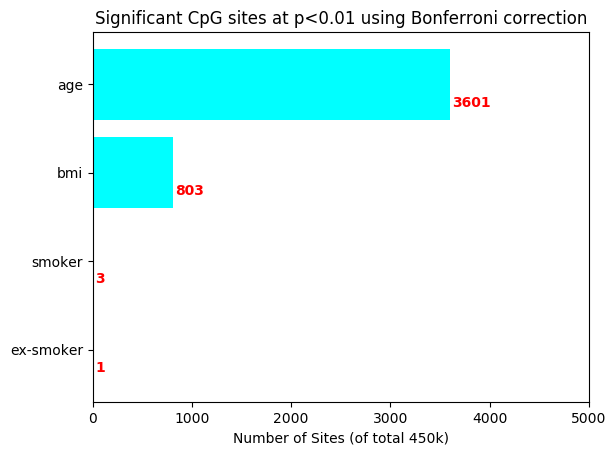

In [47]:
###### Visualization

plt.rcdefaults()
fig, ax = plt.subplots()

Features = ['age', 'bmi', 'smoker', 'ex-smoker']
y_pos = np.arange(len(Features))
performance = np.array([len(age_sites), len(bmi_sites), len(smk1_sites), len(smk2_sites)])
#error = np.random.rand(len(people))

ax.barh(y_pos, performance, align='center',
        color='cyan')
for i, v in enumerate(performance):
    #ax.text(v + 25, i + .25, str(round(v/len(m_value), 2)), color='red', fontweight='bold')
    ax.text(v + 25, i + .25, str(v), color='red', fontweight='bold')
ax.set_yticks(y_pos)
ax.set_yticklabels(Features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim((0, 5000))
ax.set_xlabel('Number of Sites (of total 450k)')
ax.set_title('Significant CpG sites at p<0.01 using Bonferroni correction')

plt.show()

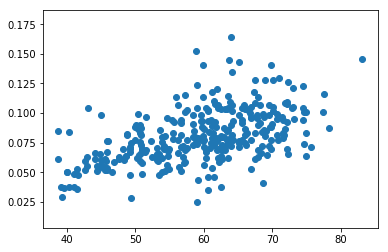

In [169]:
y = list(beta_values[177822])
age = [X[i][0] for i in range(len(X))]
#print(y, age)

plt.scatter(age, y)

In [ ]:
#####** end of code**#####